# Network Science 2024/2025
## Homework 2

**Authors:**  
- Adriano Machado (202105352)  
- Francisco da Ana (202108762)  
- João Lima (202108891)

### Auxiliary code

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

class Graph:
    def __init__(self, n: int = None, filename: str = None):
        """
        Initializes a graph with n nodes (with no connections) or loads it from a file.
        Sets all nodes as unvisited.
        """
        if filename:
            with open(filename, 'r') as file:
                first_line = file.readline().strip()
                if first_line:
                    self.n = int(first_line)
                    self.adj_matrix = [[0 for _ in range(self.n)] for _ in range(self.n)]
                for line in file:
                    a, b = map(int, line.strip().split())
                    self.add_edge(a - 1, b - 1)
        elif n is not None:
            self.n = n
            self.adj_matrix = [[0 for _ in range(n)] for _ in range(n)]
        else:
            raise ValueError("Either 'n' or 'filename' must be provided.")
        self.visited = [False] * self.n

    def add_edge(self, a : int, b : int):
        self.adj_matrix[a][b] = 1
        self.adj_matrix[b][a] = 1

    def add_edges(self, a : int, targets : list):
        for target in targets:
            self.add_edge(a, target)
 
    def has_edge(self, a, b):
        return self.adj_matrix[a][b] == 1

    def save_to_file(self, filename):
        with open(filename, 'w') as file:
            file.write(f"{self.n}\n")
            for i in range(self.n):
                for j in range(i + 1, self.n):
                    if self.adj_matrix[i][j] == 1:
                        file.write(f"{i + 1} {j + 1}\n")

    def calculate_giant_component_size(self):
        self._set_all_unvisited()
        max_size = 0
        for i in range(self.n):
            if not self.visited[i]:
                size = self.component_size(i)
                max_size = max(max_size, size)
        return max_size

    def component_size(self, node):
        stack = [node]
        size = 0
        while stack:
            current_node = stack.pop()
            if not self.visited[current_node]:
                self.visited[current_node] = True
                size += 1
                for neighbor in self._get_neighbors(current_node):
                    if not self.visited[neighbor]:
                        stack.append(neighbor)
        return size
    
    def get_degree_of_node(self, node):
        return sum(self.adj_matrix[node])
    
    def _set_all_unvisited(self):
        self.visited = [False] * self.n

    def _get_neighbors(self, node):
        return [i for i in range(self.n) if self.adj_matrix[node][i] == 1]


### **Link Analysis and PageRank**

#### Exercise 1

   PageRank  Betweenness  Closeness
A    0.0212       0.0000     0.0000
B    0.0302       0.0045     0.0909
C    0.0431       0.1136     0.1818
D    0.0524       0.0364     0.2045
E    0.0840       0.2545     0.2424
F    0.0927       0.2727     0.2066
G    0.1000       0.2727     0.1925
H    0.1062       0.2545     0.1856
I    0.1115       0.2182     0.1818
J    0.1160       0.1636     0.1796
K    0.1198       0.0909     0.1783
L    0.1230       0.0000     0.1774


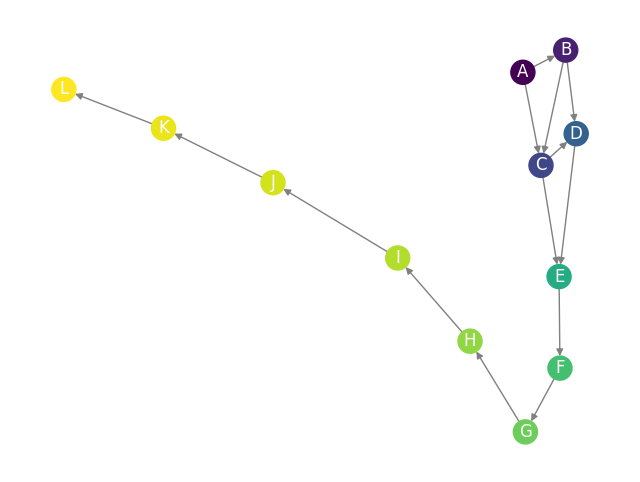

In [83]:
G = nx.DiGraph()

edges = [
    ('A', 'B'),
    ('A', 'C'),
    ('B', 'C'),
    ('B', 'D'),
    ('C', 'D'),
    ('C', 'E'),
    ('D', 'E'),
    ('E', 'F'),
    ('F', 'G'),
    ('G', 'H'),
    ('H', 'I'),
    ('I', 'J'),
    ('J', 'K'),
    ('K', 'L'),
]

G.add_edges_from(edges)

pagerank = nx.pagerank(G)
betweenness = nx.betweenness_centrality(G, normalized=True)
closeness = nx.closeness_centrality(G)

metrics = pd.DataFrame({
    'PageRank': [round(pagerank[node], 4) for node in G.nodes()],
    'Betweenness': [round(betweenness[node], 4) for node in G.nodes()],
    'Closeness': [round(closeness[node], 4) for node in G.nodes()]
}, index=G.nodes())

print(metrics)

# Positioning nodes using a layout
pos = nx.spring_layout(G, seed=42)  # You can try other layouts too, like nx.kamada_kawai_layout

# Plotting the graph
plt.figure(figsize=(8, 6))
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True)
nx.draw_networkx_nodes(G, pos, node_color=[pagerank[node] for node in G.nodes()], 
                       cmap=plt.cm.viridis, node_size=300)
nx.draw_networkx_labels(G, pos, font_size=12, font_color='white')
plt.axis('off')
plt.savefig("docs/ex1_graph.png")
plt.show()

#### Exercise 2
The damping factor **β** indicates the probability that a surfer will follow an outgoing link from the current node. This also means that there is a probability of **1 - β** that the surfer will jump to any random node in the network, even if there is no link to it.

**a)** In a PageRank setup with `β = 0.0`, the algorithm will not consider existing links/edges at all to calculate the nodes' scores. The only factor that will be considered is the number of nodes in the network. This means that all nodes will have the same score, which is equal to `1/N` (N is the number of nodes in the Graph).

**b)** In a PageRank setup with `β = 1.0`, the algorithm will only consider existing links/edges to calculate the nodes' scores. This may lead to issues in PageRank calculation suach as spider traps and dead ends.
**Spider traps** are groups of pages that only link to each other, trapping all the PageRank score inside that group forever. **Dead ends** are pages with no outgoing links that absorb PageRank but can't pass it on to other pages.

#### Exercise 3

In [84]:
class NormalizedPageRank:
    """
    Calculates the PageRank scores of a graph using the power iteration method.
    PageRank values of all nodes are stored in the page_rank attribute as a numpy array.
    Damping factor is represented by Beta. 
        - Beta represents the probability of following an existing link.
        - 1 - Beta represents the probability of jumping to any random node.
    """
    def __init__(self, graph: Graph, beta: float = 0.85, convergence_threshold: float = 1e-6):
        self.graph = graph
        self.beta = beta
        self.n = graph.n
        self.scores = np.ones(self.n) / self.n
        self.convergence_threshold = convergence_threshold
        self.scores_history = [self.scores.copy()]

    def calculate_scores(self):
        while True:
            new_scores = np.zeros(self.n)
            for j in range(self.n):
                neighbors = self.graph._get_neighbors(j)
                if neighbors:
                    for i in neighbors:
                        new_scores[j] += self.scores[i] / self.graph.get_degree_of_node(i)
            new_scores = (1 - self.beta) / self.n + self.beta * new_scores
            if np.linalg.norm(new_scores - self.scores, ord=1) < self.convergence_threshold:
                break
            self.scores = new_scores
            self.scores_history.append(self.scores.copy())

    def get_top_k_nodes(self, k: int):
        return np.argsort(self.scores)[-k:][::-1]
    
    def get_score_of_node(self, node: int):
        return self.scores[node]
    
    def reset(self):
        self.scores = np.ones(self.n) / self.n
        self.scores_history = [self.scores.copy()]

    def number_of_iterations(self):
        return len(self.scores_history) - 1

#### Exercise 4

In order to compute the PageRank scores of the described network, I've defined it in a `.txt` file stored at `docs/ex4_network.txt`

PR state at it. 0: [0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]
PR state at it. 1: [0.04571429 0.36547619 0.08619048 0.16714286 0.08619048 0.16714286
 0.08214286]
PR state at it. 2: [0.08355952 0.25194048 0.13091667 0.15682143 0.13091667 0.15338095
 0.09246429]
PR state at it. 3: [0.06425845 0.31335298 0.10869119 0.17553762 0.10869119 0.1428531
 0.08661548]
PR state at it. 4: [0.07469858 0.27888399 0.12443424 0.16708609 0.12443424 0.14832173
 0.08214114]
PR state at it. 5: [0.06883885 0.30106926 0.11617991 0.17460795 0.11617991 0.13865882
 0.08446531]
PR state at it. 6: [0.07261035 0.28709677 0.1220826  0.17136327 0.1220826  0.14440586
 0.08035857]
PR state at it. 7: [0.07023502 0.29684299 0.11878795 0.17400523 0.11878795 0.1385398
 0.08280106]
PR state at it. 8: [0.07189188 0.29027899 0.12119336 0.17286163 0.12119336 0.14227278
 0.08030799]
PR state at it. 9: [0.070776   0.29499442 0.11975346 0.17379036 0.11975346 0.13903779
 0.0818945 ]
PR state at 

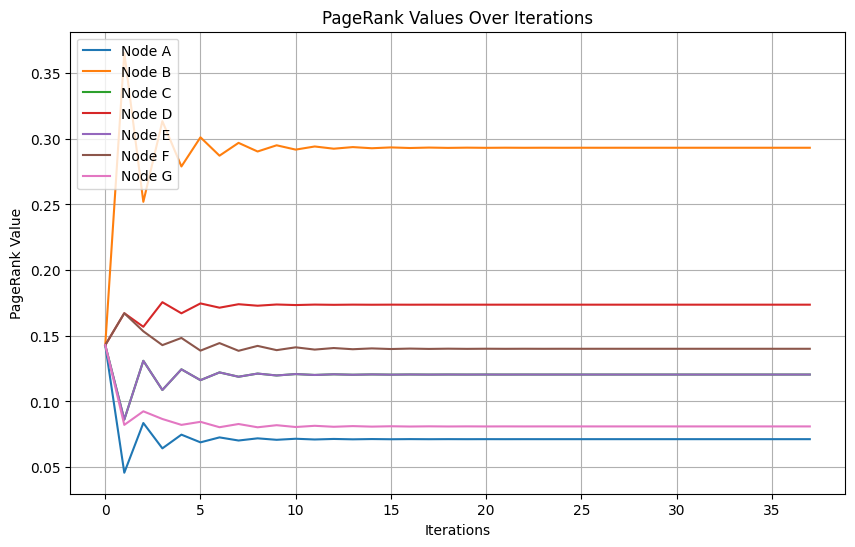

In [85]:
net4 = Graph(filename='docs/ex4_network.txt')
pr = NormalizedPageRank(net4)
pr.calculate_scores()

# Print pageranks to console
for i in range(pr.number_of_iterations()):
    print(f"PR state at it. {i}: {pr.scores_history[i]}")

# Plot pagerank values over iterations
plt.figure(figsize=(10, 6))
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
for i in range(pr.n):
    plt.plot(range(pr.number_of_iterations()), [pr.scores_history[j][i] for j in range(pr.number_of_iterations())], label=f'Node {alphabet[i]}')
plt.xlabel('Iterations')
plt.ylabel('PageRank Value')
plt.title('PageRank Values Over Iterations')
plt.legend()
plt.grid()
plt.savefig('docs/ex4_pagerank_values.png')
plt.show()

#### Exercise 5 a)

In [86]:
betas = np.arange(0.0, 1.05, 0.05)
iterations = []
scores = []
for beta in betas:
    pr = NormalizedPageRank(net4, beta=beta)
    pr.calculate_scores()
    iterations.append(pr.number_of_iterations())
    scores.append(pr.scores.copy())

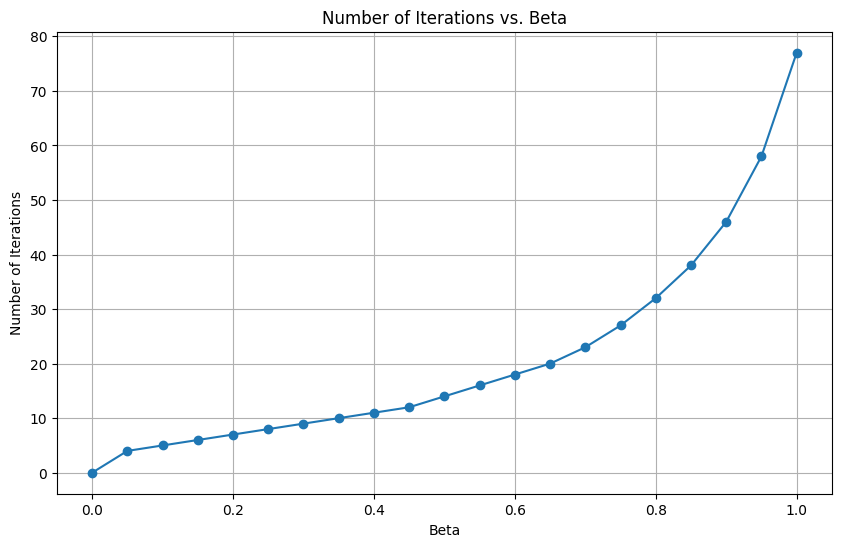

In [87]:
plt.figure(figsize=(10, 6))
plt.plot(betas, iterations, marker='o')
plt.xlabel('Beta')
plt.ylabel('Number of Iterations')
plt.title('Number of Iterations vs. Beta')
plt.grid()
plt.savefig('docs/ex5_iterations_vs_beta.png')
plt.show()

As we can see, very low values of **β** lead to a quick convergence of PageRank scores. Increasing the value of **β** leads to a slower convergence as it takes more iterations to be reached. The reason for this is that a higher damping factor places more weight on the link structure, meaning the algorithm needs more iterations for the PageRank to "flow" through the network and stabilize, whereas a lower β relies more on the random jump factor which distributes rank more uniformly and thus converges faster.

#### Exercise 5 b)

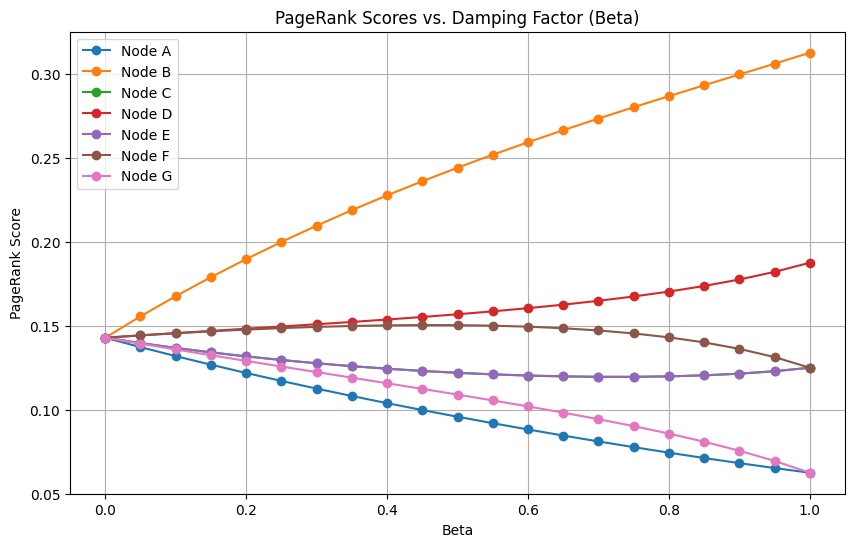

In [88]:
plt.figure(figsize=(10, 6))
for i in range(pr.n):
    plt.plot(betas, [scores[j][i] for j in range(len(betas))], marker='o', label=f'Node {alphabet[i]}')
plt.xlabel('Beta')
plt.ylabel('PageRank Score')
plt.title('PageRank Scores vs. Damping Factor (Beta)')
plt.legend()
plt.grid()
plt.savefig('docs/ex5_pagerank_scores_vs_beta.png')
plt.show()

This plot clearly shows the evolution of PageRank scores when using different values of **β**. When `β=0` all nodes have the same score, which is `1/N` (in this case, approximately 0.143 which correspondes to 1/7). As we increase the value of **β** the scores start to diverge.

Additionally, the plot displays some different curve types: nodes with sharply increasing curves (such as Node B) have a PageRank score that is heavily reliant on and benefits from the link structure. Node D shows a similar but not so heavy behaviour. These nodes become more significant as β (the weight on link-following) rises. On the other hand, nodes that depend more on the the random jump factor (1-β) are represented by steadily decreasing curves (such as Nodes A, E, and G), which become less significant as the link structure takes center stage. Node F exhibits a more intricate pattern, showing a nuanced position within the network and initially benefiting slightly from link structure before its relative importance diminishes at higher β values.

### **Community Discovery**

#### Exercise 6 a)

#### Exercise 6 b)

#### Exercise 6 c)

#### Exercise 6 d)

#### Exercise 6 e)

### **Network Motifs**

#### Exercise 7 a)

#### Exercise 7 b)

#### Exercise 7 c)

#### Exercise 7 d)

#### Exercise 7 e)